In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
# %load ../frac_diff.py
import numpy as np
import pandas as pd
from scipy import interp
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller


def getWeights(d, size):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 

    @param d A non-negative real that represents the degree of the differentiation.
    @param size The number of items .
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def getWeights_FFD(d, thres):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 

    @param d A non-negative real that represents the degree of the differentiation.
    @param thres The minimum absolute value that helps the stop adding items to the list of coefficients.
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)


def fracDiff(series, d, thres=0.01):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    value of coefficients the window will have.

    @param series A time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    # 1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    # 2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_ > thres].shape[0]
    # 3) Apply weights to values
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            # must resample if duplicate index
            test_val = series.loc[loc, name]
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any():
                continue  # exclude NAs
            try:
                df_.loc[loc] = np.dot(w[-(iloc+1):, :].T,
                                      seriesF.loc[:loc])[0, 0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def fracDiff_FFD(series, d, thres=1e-5):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    coefficient the window will have.

    @param series A DataFrame of time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    w = getWeights_FFD(d, thres)  # Constant width window (new solution)
    width = len(w)-1
    df = {}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width, seriesF.shape[0]):
            loc0 = seriesF.index[iloc1-width]
            loc1 = seriesF.index[iloc1]
            # must resample if duplicate index
            test_val = series.loc[loc1, name]
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any():
                continue  # exclude NAs
            try:
                df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df


def compute_multiple_ffd(close, threshold, dd):
    '''
    Iterates over @p close and fractionally differentiates the time series with
    @p dd degree. Uses coefficients whose absolute value is higher than @p threshold.

    @param close A DataFrame of time series to apply the fractionally differentiation.
    @param dd A non-negative real series that represents the degree of the differentiation.
    @param threshold A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose columns represent the output of the Augmented Dickey-Fuller statistic.
    '''
    out = pd.DataFrame(
        columns=['adfStat', 'pVal', 'lags', 'nObs', '95% conf', 'corr'])
    df0 = close
    for d in dd:
        # downcast to daily obs. Dropped NAs
        df1 = np.log(df0).resample('1D').last().dropna()
        df2 = fracDiff_FFD(df1, d, thres=threshold).dropna()
        corr = np.corrcoef(df1.loc[df2.index, 'Close'], df2['Close'])[0, 1]
        df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']] + \
            [corr]  # with critical value
    return out


def get_d_optim(out, conf=0.05):
    '''
    Returns the maximum differentiation degree that makes the p-value
    of @p out to be less than @p conf.

    @param out The output of compute_multiple_ffd().
    @param conf The confidence value.
    @return The optimal differentiation degree.
    '''
    return out[out.pVal < conf].pVal.idxmax()


In [4]:
def data_paths_from_periodicity(periodicity):
    if periodicity == 'hourly':
        return ['../../datasets/bitstamp_data_hourly.csv']
    elif periodicity == 'daily':
        return ['../../datasets/bitstamp_data_daily.csv']
    return ['../../datasets/bitstamp_data.csv.part1',
            '../../datasets/bitstamp_data.csv.part2',
            '../../datasets/bitstamp_data.csv.part3',
            '../../datasets/bitstamp_data.csv.part4',
            '../../datasets/bitstamp_data.csv.part5']

def load_btc_data(periodicity):
    file_paths = data_paths_from_periodicity(periodicity)
    # Función que permite convertir el formato de las fechas como unix time
    # en un objeto de fecha.
    def unix_time_to_date(x): return pd.to_datetime(x, unit='s')
    li = []
    for filename in file_paths:
        df = pd.read_csv(filename, parse_dates=[
                         'Timestamp'], date_parser=unix_time_to_date, index_col='Timestamp')
        li.append(df)
    return pd.concat(li, axis=0)

In [5]:
df = load_btc_data('daily')

In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)'], dtype='object')

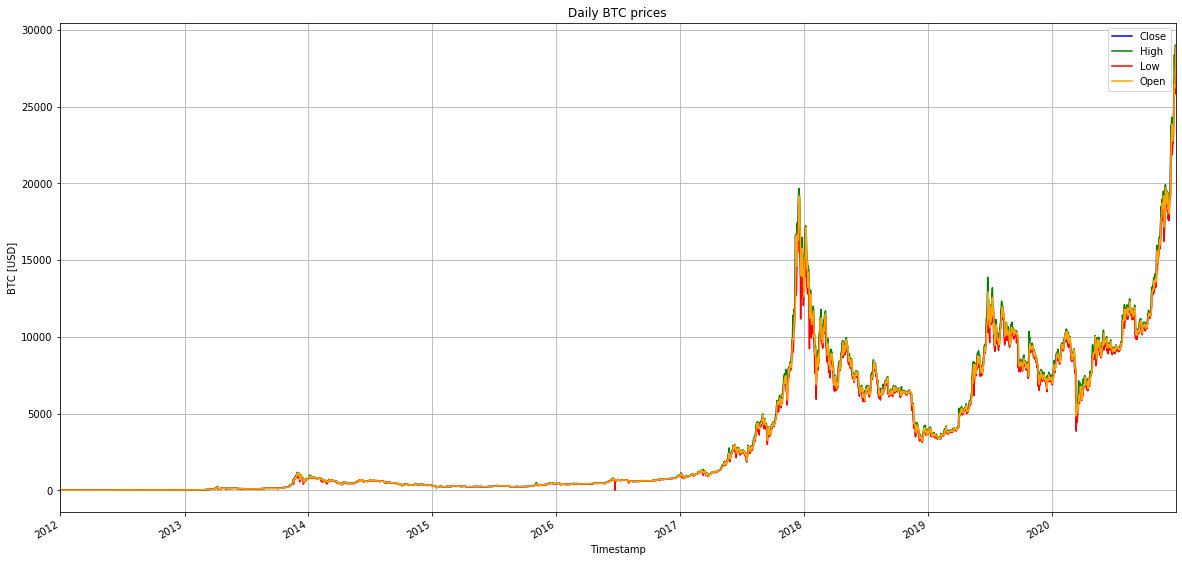

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df.plot(kind='line',y='Close', color='blue', ax=ax)
df.plot(kind='line',y='High', color='green', ax=ax)
df.plot(kind='line',y='Low', color='red', ax=ax)
df.plot(kind='line',y='Open', color='orange', ax=ax)
plt.title('Daily BTC prices')
plt.ylabel('BTC [USD]')
plt.grid()
plt.show()

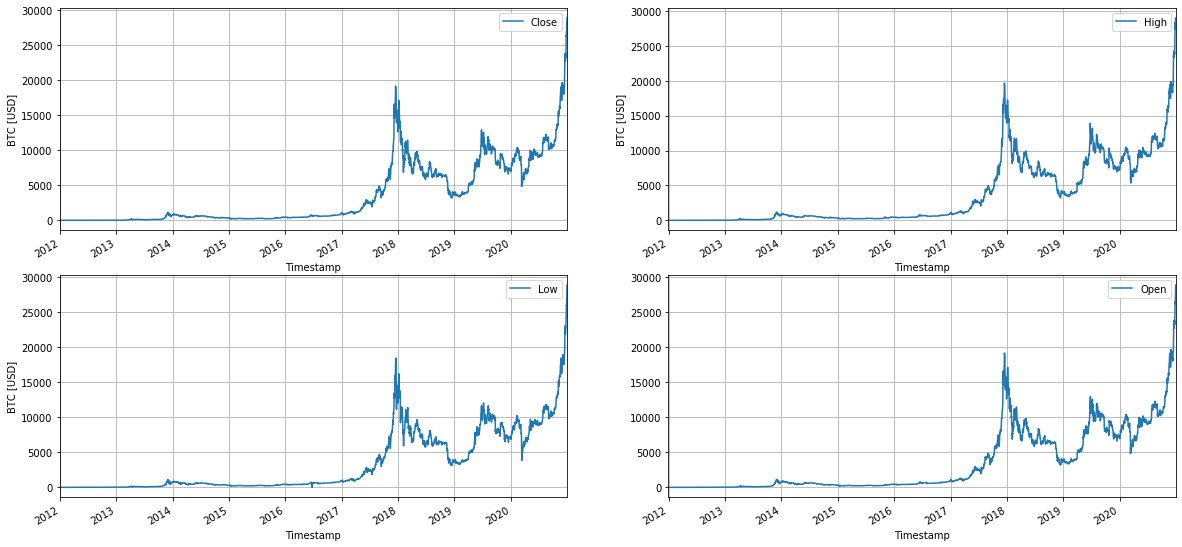

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
df.plot(kind='line',y='Close', ax=ax[0,0])
df.plot(kind='line',y='High', ax=ax[0,1])
df.plot(kind='line',y='Low', ax=ax[1,0])
df.plot(kind='line',y='Open', ax=ax[1,1])

ax[0,0].set_ylabel('BTC [USD]')
ax[0,1].set_ylabel('BTC [USD]')
ax[1,0].set_ylabel('BTC [USD]')
ax[1,0].set_ylabel('BTC [USD]')

ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

plt.show()

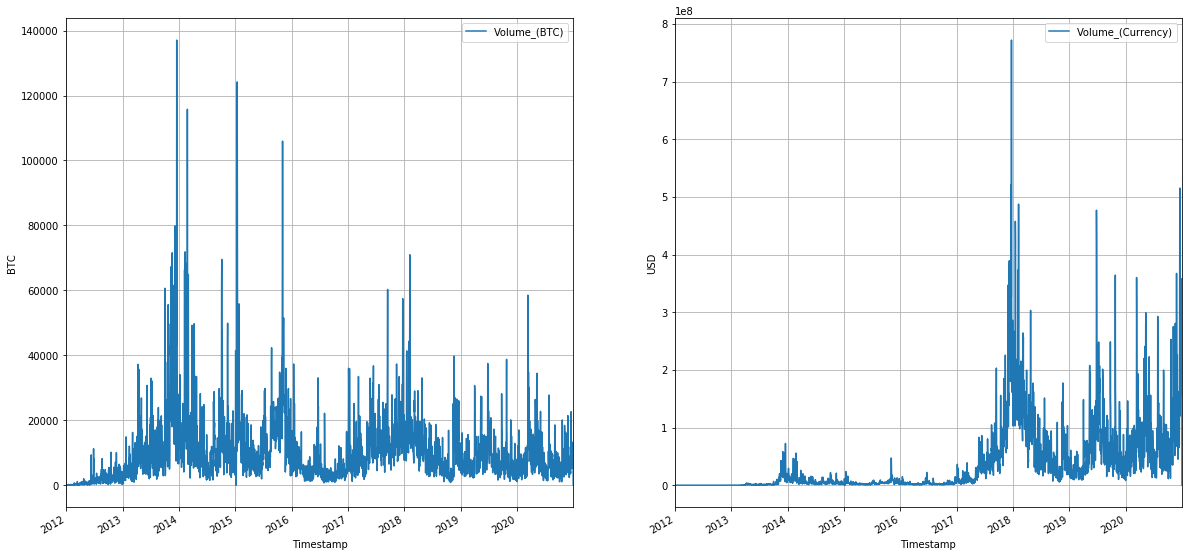

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
df.plot(kind='line',y='Volume_(BTC)', ax=ax[0])
df.plot(kind='line',y='Volume_(Currency)', ax=ax[1])

ax[0].set_ylabel('BTC')
ax[1].set_ylabel('USD')

ax[0].grid()
ax[1].grid()

plt.show()

In [17]:
df['Volume_(BTC)_log'] = np.log(df['Volume_(BTC)'])
df['Volume_(Currency)_log'] = np.log(df['Volume_(Currency)'])

/home/agustin/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


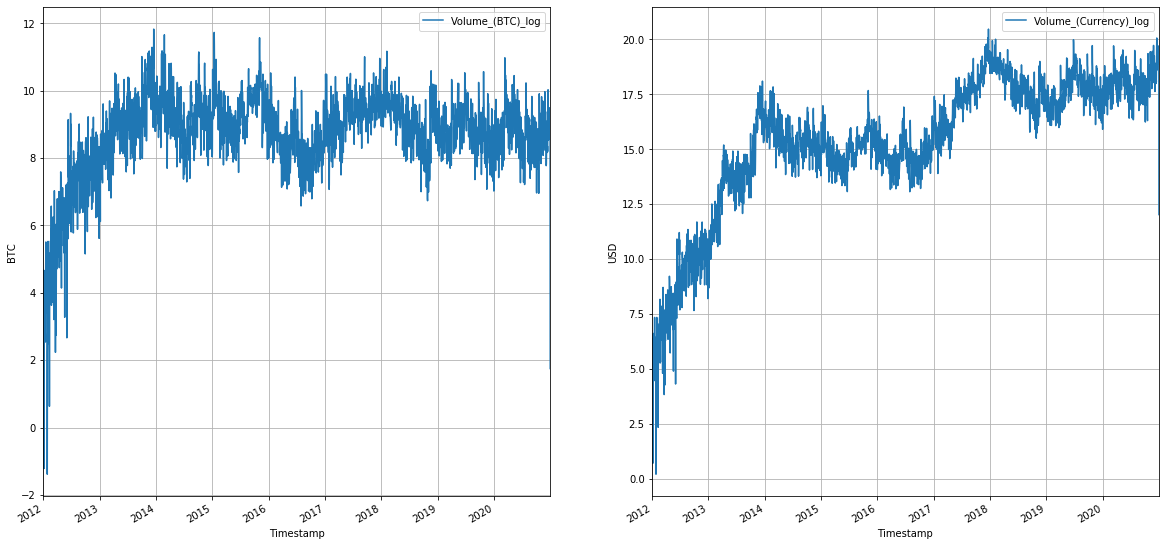

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
df.plot(kind='line',y='Volume_(BTC)_log', ax=ax[0])
df.plot(kind='line',y='Volume_(Currency)_log', ax=ax[1])

ax[0].set_ylabel('BTC')
ax[1].set_ylabel('USD')

ax[0].grid()
ax[1].grid()

plt.show()

In [41]:
# Computo una lista de valores de d (el grado de diferenciación),
# y diferencio la serie de precios.
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['Close'].to_frame(), 1e-3, ds)
print(out)

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -1.586943  4.901489e-01   1.0  3284.0 -2.862421  1.000000
0.1  -1.688057  4.372759e-01   1.0  3223.0 -2.862437  0.999591
0.2  -1.802431  3.792553e-01   1.0  3212.0 -2.862440  0.997162
0.3  -2.443356  1.298714e-01   1.0  3219.0 -2.862438  0.991730
0.4  -3.528404  7.286882e-03   1.0  3230.0 -2.862435  0.981576
0.5  -5.274327  6.187546e-06   1.0  3241.0 -2.862432  0.962623
0.6  -7.886939  4.543185e-12   1.0  3251.0 -2.862429  0.927296
0.7 -12.140384  1.656231e-22   1.0  3259.0 -2.862427  0.856569
0.8 -17.454549  4.632999e-30   1.0  3267.0 -2.862425  0.740889
0.9 -27.088433  0.000000e+00   1.0  3273.0 -2.862423  0.514307
1.0 -41.137859  0.000000e+00   1.0  3283.0 -2.862421 -0.008306


Promedio de valores críticos para el estadístico al 5%: -2.8624299761497833
Valor óptimo de d: 0.4


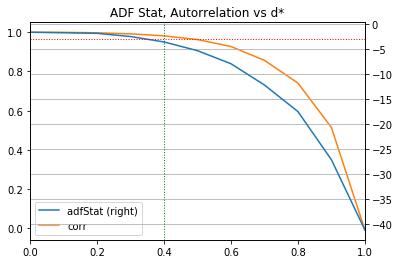

In [42]:
# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d = get_d_optim(out, conf=0.05)
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelation vs d*')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d))

In [32]:
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['High'].to_frame().rename(columns={'High':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -1.599375  4.839075e-01   1.0  3284.0 -2.862421  1.000000
0.1  -1.691161  4.356721e-01   1.0  3223.0 -2.862437  0.999586
0.2  -1.818367  3.713820e-01   1.0  3212.0 -2.862440  0.997147
0.3  -2.426434  1.344141e-01   1.0  3219.0 -2.862438  0.991822
0.4  -3.408120  1.068517e-02   1.0  3230.0 -2.862435  0.982216
0.5  -5.069222  1.616060e-05   1.0  3241.0 -2.862432  0.964957
0.6  -7.461448  5.340621e-11   1.0  3251.0 -2.862429  0.933803
0.7 -11.252415  1.699142e-20   1.0  3259.0 -2.862427  0.871352
0.8 -16.240023  3.735732e-29   1.0  3267.0 -2.862425  0.769404
0.9 -24.977961  0.000000e+00   1.0  3273.0 -2.862423  0.552720
1.0 -38.075180  0.000000e+00   1.0  3283.0 -2.862421 -0.012505


0.4

In [33]:
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['Low'].to_frame().rename(columns={'Low':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -1.720842  4.204071e-01   1.0  3284.0 -2.862421  1.000000
0.1  -2.401591  1.412879e-01   1.0  3223.0 -2.862437  0.999104
0.2  -3.749899  3.463577e-03   1.0  3212.0 -2.862440  0.993103
0.3  -6.047048  1.304299e-07   1.0  3219.0 -2.862438  0.974950
0.4  -9.652250  1.424462e-16   1.0  3230.0 -2.862435  0.930758
0.5 -15.002156  1.085842e-27   1.0  3241.0 -2.862432  0.841295
0.6 -22.409550  0.000000e+00   1.0  3251.0 -2.862429  0.698554
0.7 -32.261550  0.000000e+00   1.0  3259.0 -2.862427  0.520322
0.8 -42.547329  0.000000e+00   1.0  3267.0 -2.862425  0.362809
0.9 -53.601391  0.000000e+00   1.0  3273.0 -2.862423  0.210775
1.0 -62.198718  0.000000e+00   1.0  3283.0 -2.862421  0.029031


0.2

In [34]:
ds = np.linspace(0, 1, 11)
out = compute_multiple_ffd(df['Open'].to_frame().rename(columns={'Open':'Close'}), 1e-3, ds)
print(out)
optim_d = get_d_optim(out, conf=0.05)
optim_d

       adfStat          pVal  lags    nObs  95% conf      corr
0.0  -1.649084  4.575180e-01   1.0  3284.0 -2.862421  1.000000
0.1  -1.644670  4.598217e-01   1.0  3223.0 -2.862437  0.999591
0.2  -1.848908  3.564644e-01   1.0  3212.0 -2.862440  0.997163
0.3  -2.434603  1.322071e-01   1.0  3219.0 -2.862438  0.991724
0.4  -3.489088  8.271788e-03   1.0  3230.0 -2.862435  0.981545
0.5  -5.317172  5.044540e-06   1.0  3241.0 -2.862432  0.962572
0.6  -7.869184  5.038582e-12   1.0  3251.0 -2.862429  0.927035
0.7 -12.315478  6.937585e-23   1.0  3259.0 -2.862427  0.852716
0.8 -18.081059  2.586882e-30   1.0  3267.0 -2.862425  0.734065
0.9 -27.672294  0.000000e+00   1.0  3273.0 -2.862423  0.504968
1.0 -41.832800  0.000000e+00   1.0  3283.0 -2.862421 -0.008190


0.4

In [43]:
df['Close_FFD'] = fracDiff_FFD(df['Close'].to_frame(), d=0.4, thres=1e-3)

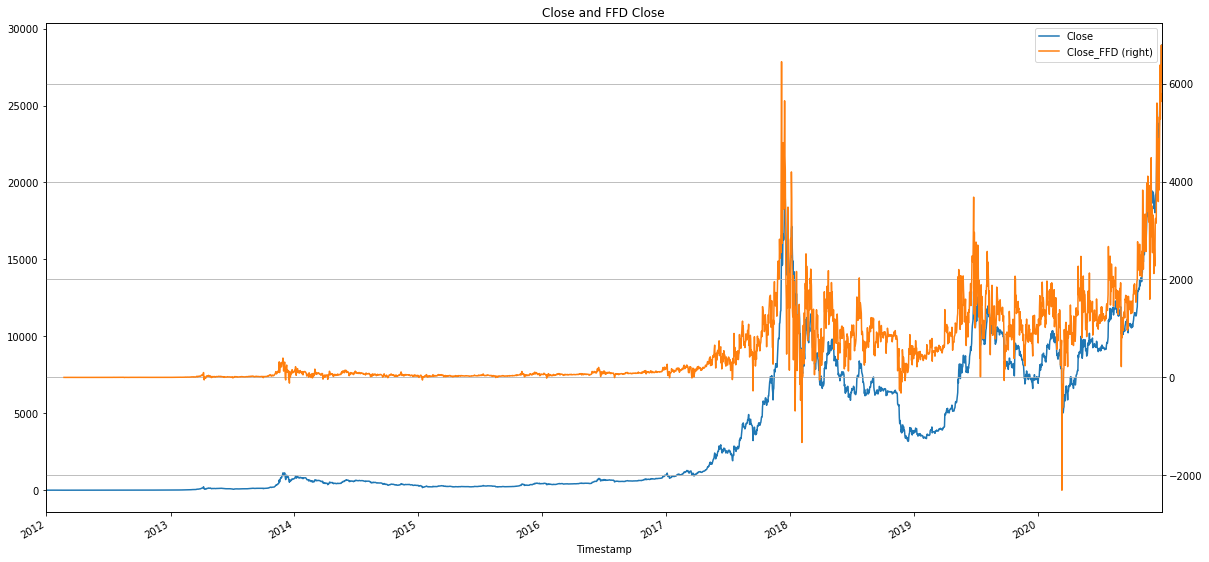

In [44]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
df[['Close','Close_FFD']].plot(kind='line', secondary_y='Close_FFD',  ax=ax)
plt.title('Close and FFD Close')
plt.xlabel('Timestamp')
plt.grid()
plt.show()

In [46]:
# %load ../features.py
import numpy as np


def rsi(close, window_length=14):
    """
    Computes the RSI index over a price series sampled at constant time step.

    @param close A series that contains the close price values.
    @param window_length The number of events to apply an average.
    @return A series that contains the RSI index of the close price series.
    """
    # Get the difference in price from previous step
    delta = close.diff()
    # Get rid of the first row, which is NaN since it did not have a previous
    # row to calculate the differences
    delta = delta[1:]
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    # Calculate the SMA
    roll_up = up.rolling(window_length).mean()
    roll_down = down.abs().rolling(window_length).mean()
    # Calculate the RSI based on SMA
    relative_strength = roll_up / roll_down
    return 100.0 - (100.0 / (1.0 + relative_strength))


def log_ret(close):
    """
    Computes the log of the returns inter sample.

    @param close A series that contains the close price values.
    @return A series that contains the log of the inter sample returns
    """
    return np.log(close).diff()


def autocorr(close, window_length=50, lag=1):
    """
    Computes the auto correlation of the price series.

    @param close A series that contains the close price values.
    @param window_length The window size.
    @param lag The lag positions to consider when computing the auto correlation.
    @return A series that contains the auto correlation.
    """
    log_ret_series = log_ret(close)
    return \
        log_ret_series.rolling(window=window_length,
                               min_periods=window_length,
                               center=False).apply(lambda x: x.autocorr(lag=1), raw=False)


def volatility(close, window_length=50):
    """
    Computes the rolling volatility of prices for a given window length.

    @param close A series that contains the close price values.
    @param window_length The window size.
    @return A series of price volatility.
    """
    log_ret_series = log_ret(close)
    return \
        log_ret_series.rolling(window=window_length,
                               min_periods=window_length,
                               center=False).std()


In [47]:
RSI_WINDOW_LENGTHS = [5, 10, 15, 30]            # RSI

for window_length in RSI_WINDOW_LENGTHS:
    df['rsi_{}'.format(window_length)] = rsi(df['Close'], window_length)


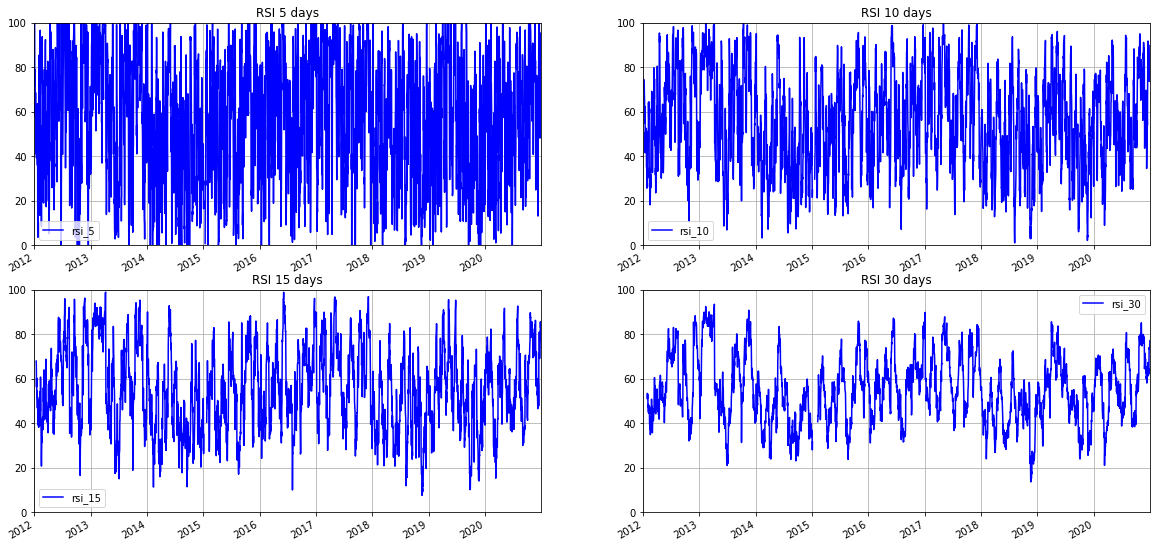

In [51]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

df.plot(kind='line',y='rsi_5', color='blue', ax=ax[0][0])
df.plot(kind='line',y='rsi_10', color='blue', ax=ax[0][1])
df.plot(kind='line',y='rsi_15', color='blue', ax=ax[1][0])
df.plot(kind='line',y='rsi_30', color='blue', ax=ax[1][1])

ax[0][0].set_title('RSI 5 days')
ax[0][1].set_title('RSI 10 days')
ax[1][0].set_title('RSI 15 days')
ax[1][1].set_title('RSI 30 days')

ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()

ax[0][0].set_ylim(0, 100)
ax[0][1].set_ylim(0, 100)
ax[1][0].set_ylim(0, 100)
ax[1][1].set_xlabel("")

ax[0][0].set_xlabel("")
ax[0][1].set_xlabel("")
ax[1][0].set_xlabel("")
ax[1][1].set_xlabel("")

plt.show()

In [52]:
# Computo el logaritmo de los retornos entre muestras.
df['log_ret'] = log_ret(df['Close'])

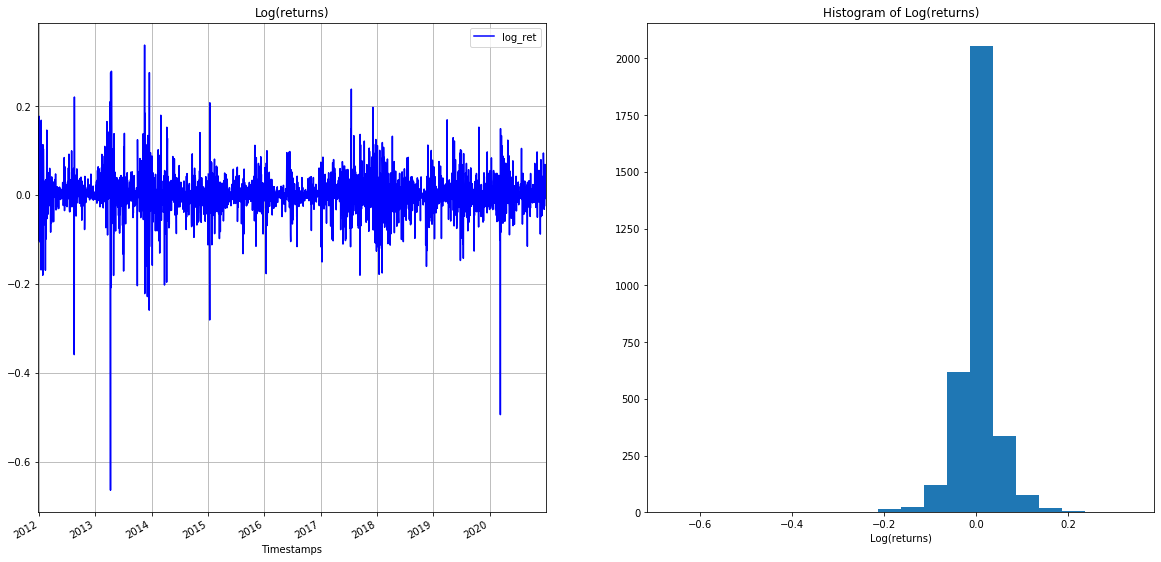

In [63]:
# Ploteamos la series.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
df.plot(kind='line',y='log_ret', color='blue', ax=ax[0])
df['log_ret'].hist(bins=20, ax=ax[1])

ax[0].set_title('Log(returns)')
ax[1].set_title('Histogram of Log(returns)')

ax[0].set_xlabel('Timestamps')
ax[1].set_xlabel('Log(returns)')

ax[0].grid()
ax[1].grid()

plt.show()

In [65]:
VOLATILITY_WINDOW_LENGTHS = [5, 10, 15, 30]     # Volatility

for window_length in VOLATILITY_WINDOW_LENGTHS:
    df['vol_{}'.format(window_length)] = volatility(df['Close'], window_length)

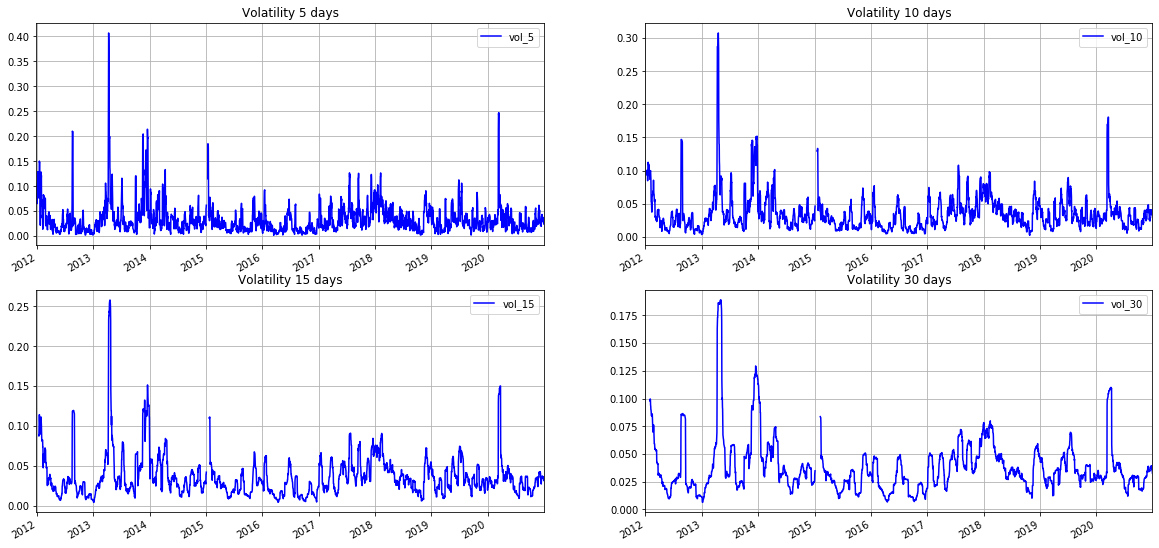

In [67]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

df.plot(kind='line',y='vol_5', color='blue', ax=ax[0][0])
df.plot(kind='line',y='vol_10', color='blue', ax=ax[0][1])
df.plot(kind='line',y='vol_15', color='blue', ax=ax[1][0])
df.plot(kind='line',y='vol_30', color='blue', ax=ax[1][1])

ax[0][0].set_title('Volatility 5 days')
ax[0][1].set_title('Volatility 10 days')
ax[1][0].set_title('Volatility 15 days')
ax[1][1].set_title('Volatility 30 days')

ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()

ax[0][0].set_xlabel("")
ax[0][1].set_xlabel("")
ax[1][0].set_xlabel("")
ax[1][1].set_xlabel("")

plt.show()

In [69]:
AUTOCORR_LAGS = [1, 3, 5]                       # Auto correlation.
AUTOCORR_WINDOW_LENGTHS = [5, 10, 15, 30, 45]
for window_length in AUTOCORR_WINDOW_LENGTHS:
    for lag in AUTOCORR_LAGS:
        df['autocorr_{}_{}'.format(lag, window_length)] = autocorr(df['Close'], window_length, lag)

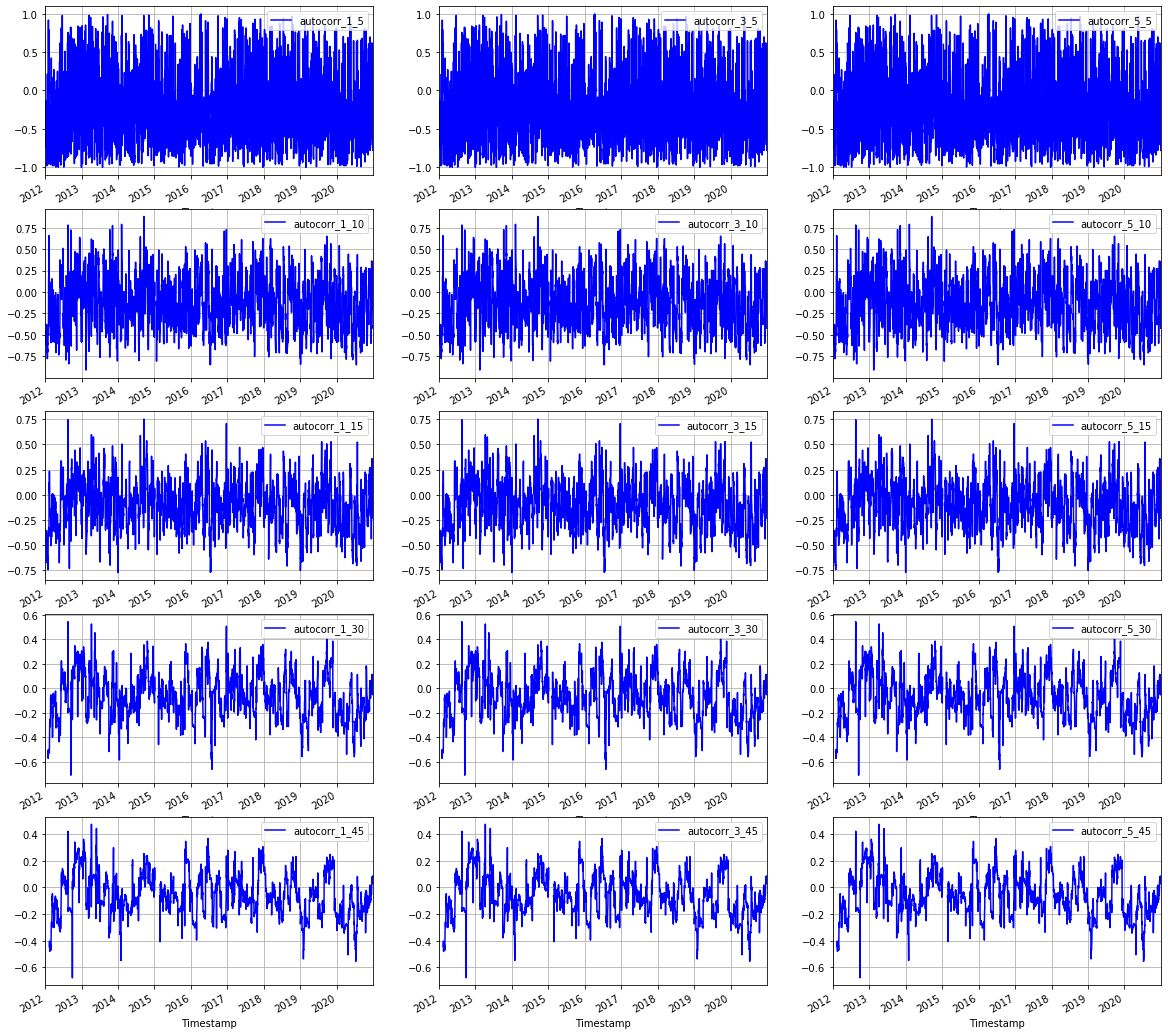

In [74]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20,20))

df.plot(kind='line',y='autocorr_1_5', color='blue', ax=ax[0][0])
df.plot(kind='line',y='autocorr_3_5', color='blue', ax=ax[0][1])
df.plot(kind='line',y='autocorr_5_5', color='blue', ax=ax[0][2])

df.plot(kind='line',y='autocorr_1_10', color='blue', ax=ax[1][0])
df.plot(kind='line',y='autocorr_3_10', color='blue', ax=ax[1][1])
df.plot(kind='line',y='autocorr_5_10', color='blue', ax=ax[1][2])

df.plot(kind='line',y='autocorr_1_15', color='blue', ax=ax[2][0])
df.plot(kind='line',y='autocorr_3_15', color='blue', ax=ax[2][1])
df.plot(kind='line',y='autocorr_5_15', color='blue', ax=ax[2][2])

df.plot(kind='line',y='autocorr_1_30', color='blue', ax=ax[3][0])
df.plot(kind='line',y='autocorr_3_30', color='blue', ax=ax[3][1])
df.plot(kind='line',y='autocorr_5_30', color='blue', ax=ax[3][2])

df.plot(kind='line',y='autocorr_1_45', color='blue', ax=ax[4][0])
df.plot(kind='line',y='autocorr_3_45', color='blue', ax=ax[4][1])
df.plot(kind='line',y='autocorr_5_45', color='blue', ax=ax[4][2])

for i in range(0, 3):
    for j in range(0, 5):
        ax[j][i].grid()

plt.show()